# Analysing Glassdoor Reviews: Impact of Job Satisfaction on Employee Retention and Firm Performance in the IT Industry

The goal here is to create a **linear regression model** to help with the titular objective. We want to determine the impact of **job satisfaction** on:
1. **Employee retention**, and
2. **Firm performance**,
3. within the **IT industry** only.

Our data sources are **Glassdoor**, **Yahoo Finance** for retrieving measures of firm financial performance, and a **Ticker** dataset to match company names with their tickers, ensuring that financial data can be retrieved for the companies reviewed on Glassdoor. 

To achieve our goal, we'll follow these steps:
1. Scrape Glassdoor reviews
2. Clean Glassdoor data
3. Retrieve tickers of the **top public IT firms**, effectively restricting the scope to only companies within the IT Industry, and only those with publicly available financial data
4. Merge datasets
5. Clean merged data
6. Exploratory data analysis
7. Extract employee retention data from Glassdoor review data
8. Retrieve financial performance data
9. Convert data to numerical values where possible, and prepare final database for input to the linear regression model
10. Run the linear regression model and determine coefficients


## Step 1: Scrape Glassdoor reviews

Glassdoor reviews have been pre-scraped using selenium chromedriver. Here's an example of what we're scraping:

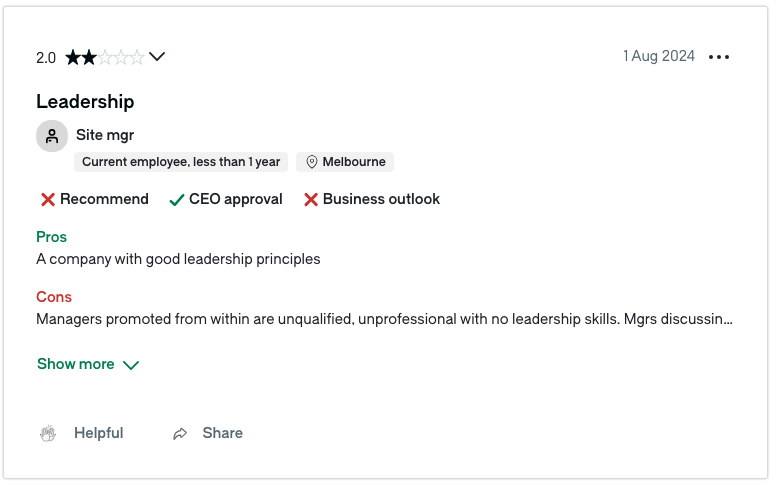

So, we might expect the following columns:
- overall rating
- title
- employee status
- recommend
- CEO approval
- business outlook
- pros
- cons
- date

and of course **company**. On top of that, each review also comes with category ratings:

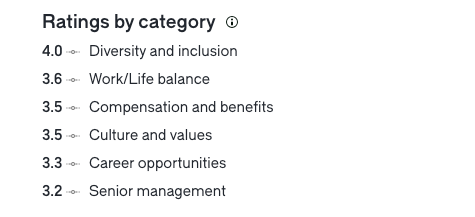

So we can expect those columns too. 

With the scraping complete, let's move to data inspection and cleaning.

## Step 2: Clean Glassdoor Data

First let's get a preview of the data.

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('all-reviews.csv', low_memory=False)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9901889 entries, 0 to 9901888
Data columns (total 19 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   rating                     float64
 1   title                      object 
 2   status                     object 
 3   pros                       object 
 4   cons                       object 
 5   advice                     object 
 6   Recommend                  object 
 7   CEO Approval               object 
 8   Business Outlook           object 
 9   Career Opportunities       object 
 10  Compensation and Benefits  object 
 11  Senior Management          object 
 12  Work/Life Balance          object 
 13  Culture & Values           float64
 14  Diversity & Inclusion      float64
 15  firm_link                  object 
 16  date                       object 
 17  job                        object 
 18  index                      float64
dtypes: float64(4), object(15)
memory usage: 1.

Nice. So we have **9,901,889** rows, 19 columns, and all the expected columns from the images above. Let's have a look at the data itself.

In [2]:
df.head(2)

,rating,title,status,pros,cons,advice,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,Diversity & Inclusion,firm_link,date,job,index
0,5.0,Good,"Current Employee, more than 10 years",Knowledge gain of complete project,Financial growth and personal growth,NaN,v,o,v,3,3,3,3,3.0,3.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Nov 19, 2022",Manager Design,NaN
1,4.0,Good,"Former Employee, less than 1 year","Good work,good work , flexible, support","Good,work, flexible,good support, good team work",NaN,v,o,o,4,4,4,4,4.0,4.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Jan 29, 2022",Anonymous Employee,NaN


Looks good. Things to note here:
- there's clearly some null data
- firm link doesn't actually contain the company, just some sort of URL
- there's a mismatch in typing between some of the numerical columns - integer vs float
- the company name will need to be extracted from the firm link
- the columns (Recommend, CEO Approval, Business Outlook) are represented by letters

This letter ratings are as follows:
- **v = Positive**
- **r = Mild**
- **x = Negative**
- **o = No opinion**

To actually work with these, we'll need to decide how to convert these accurately to a numerical scale later on.

For now, let's start cleaning the data.

In [3]:
print(df.isnull().sum())

rating                           171
title                          39424
status                           171
pros                             188
cons                             234
advice                       9901876
Recommend                        171
CEO Approval                     171
Business Outlook                 171
Career Opportunities         1848262
Compensation and Benefits    1878091
Senior Management            1975466
Work/Life Balance            1894490
Culture & Values             2246773
Diversity & Inclusion        6544282
firm_link                          0
date                             171
job                              171
index                        9740269
dtype: int64


Clearly there is a lot of missing data, so we have to decide what to do with it.

There are **9.9M+** rows, and the **'advice'** column is missing almost all of these, so we can drop that. 

Now, it looks like **Diversity & Inclusion** is missing more than half the rows, so it was probably introduced recently. Seeing as we have all the other measures, it won't impact our models too much if we drop it, and besides, it isn't a great measure of job satisfaction.

The **index** column seems to be unnecessary, so that can be dropped too.

In [4]:
df.drop(columns=['advice','index','Diversity & Inclusion'], inplace=True)

Great. From here, we need to decide how to deal with the remaining missing values. We shouldn't need to remove any more columns - the simplest solution will probably be to just remove all rows with missing values. If we do so we'll lose **2,246,773** rows due to the Nulls in Culture & Values, but given the huge dataset size that's not a bad tradeoff. Let's try it.

In [5]:
cleaned_df = df.dropna()
print(cleaned_df.isnull().sum())

rating                       0
title                        0
status                       0
pros                         0
cons                         0
Recommend                    0
CEO Approval                 0
Business Outlook             0
Career Opportunities         0
Compensation and Benefits    0
Senior Management            0
Work/Life Balance            0
Culture & Values             0
firm_link                    0
date                         0
job                          0
dtype: int64


No more Nulls. Let's take a look at our data now.

In [6]:
print(cleaned_df.shape)
cleaned_df.head(2)

(7488389, 16)


,rating,title,status,pros,cons,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,firm_link,date,job
0,5.0,Good,"Current Employee, more than 10 years",Knowledge gain of complete project,Financial growth and personal growth,v,o,v,3,3,3,3,3.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Nov 19, 2022",Manager Design
1,4.0,Good,"Former Employee, less than 1 year","Good work,good work , flexible, support","Good,work, flexible,good support, good team work",v,o,o,4,4,4,4,4.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Jan 29, 2022",Anonymous Employee


Great, we now have **7.4M+** rows of complete data. 

Next, we'll focus on merging this data with the top public IT firm Tickers - the reason being that this will cut out a lot more of the data, making future calculations simpler and faster. First thing we need to do is extract the firm name from the **firm_link** URL. Let's see:

### Converting firm_link to Company Name

First off, some examples to see what we're working with.

In [7]:
import re
import urllib.parse

print(cleaned_df.firm_link[1])
print(cleaned_df.firm_link[469])
print(cleaned_df.firm_link[1901])
print(cleaned_df.firm_link[5901])
print(cleaned_df.firm_link[99802])

Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm
https://www.glassdoor.com/Reviews/Canada-Life-Reviews-E23636.htm
Reviews/SS&C-Advent-Reviews-E646079.htm
https://www.glassdoor.com/Reviews/Boston-Red-Sox-Reviews-E5205.htm
Reviews/Chipotle-Reviews-E1370610.htm


With textual URL data like this, there can always be interesting UTF-8 character representations using the % sign. For example, accents can't be typed into URLs.

In [8]:
for index, firm_link in cleaned_df.firm_link.items():
    if "%" in firm_link:
        print(firm_link)
        print(index)
        break

https://www.glassdoor.com/Reviews/Universit%C3%A9-Toulouse-III-Paul-Sabatier-Reviews-E753896.htm
135445


A good example here with an accent. The urllib.parse library provides an easy way to convert these representations into the correct Unicode characters:

In [13]:
ctr = 0
for index, firm_link in cleaned_df['firm_link'].items():
    if "%" in firm_link:
        cleaned_df.at[index, 'firm_link'] = urllib.parse.unquote(firm_link)

In [14]:
print(cleaned_df.firm_link.loc[135445])

https://www.glassdoor.com/Reviews/Université-Toulouse-III-Paul-Sabatier-Reviews-E753896.htm


Looks like we've fixed it.

Next up, we need to extract the firm names. It's always after 'Reviews/' and before '-Reviews'. We'll use regex. To make things simpler, we'll also remove hyphens because the URL links add a hyphen between each word of the company. This is a significant change, but it also makes it easier to merge with the Ticker data.

In [15]:
cleaned_df = cleaned_df.rename(columns={'firm_link':'firm'})
cleaned_df['firm'] = cleaned_df['firm'].str.extract(r'(?<=Reviews\/)(.*)(?=-Reviews)')
cleaned_df['firm'] = cleaned_df['firm'].str.replace('-',' ', regex=False)
print(cleaned_df['firm'].head(2))
print(cleaned_df['firm'].tail(2))

0    Baja Steel and Fence
1    Baja Steel and Fence
Name: firm, dtype: object
9901887    Victoria Inn Hotel & Convention Centre
9901888    Victoria Inn Hotel & Convention Centre
Name: firm, dtype: object


Done. Ready to merge with the Ticker data by firm name.

## Step 3: Retrieve top public IT firm Tickers

We've retrieved a ticker dataset of the top public IT companies retrieved from https://companiesmarketcap.com/tech/largest-tech-companies-by-market-cap/.

By merging this dataset with our own, we can very easily fetch financial data for each company being reviewed.

A good way to match Ticker to company name will be with some sort of fuzzy match / cosine similarity score.

In [16]:
tech_firm_tickers_df = pd.read_csv('tech-firms-by-market-cap.csv')
print(tech_firm_tickers_df.head(5))
print(tech_firm_tickers_df.shape, "\n")
print(tech_firm_tickers_df.isnull().sum())
tech_firm_tickers_df = tech_firm_tickers_df.dropna()
print("\n", tech_firm_tickers_df.shape)

   Rank               Name Symbol     marketcap  price (USD)        country
0     1          Microsoft   MSFT  3.073560e+12       413.54  United States
1     2              Apple   AAPL  2.786360e+12       181.71  United States
2     3             NVIDIA   NVDA  2.303500e+12       921.40  United States
3     4  Alphabet (Google)   GOOG  2.086900e+12       169.83  United States
4     5             Amazon   AMZN  1.963730e+12       188.70  United States
(952, 6) 

Rank           0
Name           0
Symbol         1
marketcap      0
price (USD)    0
country        0
dtype: int64

 (951, 6)


Interesting. So we have **951** companies in the Ticker dataset.

In [17]:
glassdoor_companies = pd.DataFrame(cleaned_df['firm'].unique(), columns=['Firm'])
print(glassdoor_companies.shape)

(31750, 1)


Meanwhile, we have **31,750** in the Glassdoor dataset. Let's hope we don't lose too much data in the merge.

Let's start with a simple equality match:

In [18]:
ctr = 0
for company1 in tech_firm_tickers_df['Name']:
    for company2 in glassdoor_companies['Firm']:
        if company1.lower() == company2.lower():
            ctr += 1
            break
print("%s matches on equality." % ctr)

211 matches on equality.


211 is not a lot - let's use a more advanced option. For more details, check out https://github.com/DeNederlandscheBank/name_matching.

In [19]:
from name_matching.name_matcher import NameMatcher

matcher = NameMatcher(top_n=500,
    number_of_rows=31750,
    lowercase=True,
    punctuations=True,
    remove_ascii=True,
    legal_suffixes=False,
    common_words=True,
    verbose=True)

In [20]:
matcher.load_and_process_master_data('Firm', glassdoor_companies)
matches = matcher.match_names(to_be_matched=tech_firm_tickers_df, column_matching='Name')

preprocessing...

preprocessing complete 
 searching for matches...



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


possible matches found   
 fuzzy matching...



100%|█████████████████████████████████████████| 951/951 [04:57<00:00,  3.19it/s]

done


In [21]:
print(matches.head(2))
print((matches['score'] == 0.0).sum().sum())
print((matches['score'] == 100.0).sum().sum())
print((matches['score'] >= 75.0).sum().sum())
print(matches.isnull().sum())

  original_name match_name  score  match_index
0     microsoft  microsoft  100.0         4708
1         apple      apple  100.0         9166
71
237
350
original_name    0
match_name       0
score            0
match_index      0
dtype: int64


Interesting. This time we got **350** company names with a matching score of greater than 75%, and **237** with a match of 100%. **This isn't great** - some of the companies with 75% may not be the same company at all, and there are many edge cases. As such, I've exported the matching data to clean the matches manually.

In [22]:
matches.to_csv('matches.csv', index=False)

I used this next section of code to check the number of reviews for unknown companies - if they have few reviews, then they aren't as useful to our analysis so I dropped them.

In [23]:
companies = cleaned_df['firm'].copy()
comp_counts = companies.value_counts()
comp_pcts = companies.value_counts(normalize=True)

checks = ['sohu', 'cognizant']


for company, count in comp_counts.items():
    for check in checks:
        if check in company.lower() and count > 50:
            print("{} reviews, {:.2f}%: {}".format(count, comp_pcts[company]*100, company))

64066 reviews, 0.86%: Cognizant Technology Solutions


I then saved the updated matches to a new file - **matches-updated.csv**. The match index hadn't changed, so I also added back the Ticker column from the top tickers dataset. If there wasn't a match, I left the column empty which would show up as Null. Let's have a look:

In [24]:
matches_updated = pd.read_csv('matches-updated.csv', low_memory=False)
print(matches_updated.head(2))
print(matches_updated.shape, "\n")
print(matches_updated.isnull().sum())
matches_updated = matches_updated.dropna()
print("\n", matches_updated.shape)

  match_name Symbol
0  microsoft   MSFT
1      apple   AAPL
(967, 2) 

match_name    649
Symbol          1
dtype: int64

 (318, 2)


Our final number of matches: **318**. This isn't amazing but we'll see how many reviews we're left with. Given that the top public companies will have a significant majority of the reviews, this shouldn't cut out too much from the data - the main cut will come from reviews of companies outside the IT industry.

Next up: the merge.

## Step 4: Merge Datasets

Before merging, let's briefly prepare both datasets. We're dropping the 'index' column - this isn't needed any longer.

In [25]:
tickers_df = matches_updated.rename(columns={"match_name": "firm", "Symbol": "Ticker"})
tickers_df = tickers_df.reset_index(drop=True)
print(tickers_df.head(2))
cleaned_df['firm'] = cleaned_df['firm'].apply(lambda x: x.lower())
print(cleaned_df['firm'].head(2))

        firm Ticker
0  microsoft   MSFT
1      apple   AAPL
0    baja steel and fence
1    baja steel and fence
Name: firm, dtype: object


**Merge!**

In [26]:
merged_df = cleaned_df.merge(tickers_df, how='right')
print(merged_df.isnull().sum())
print(merged_df.shape)
merged_df = merged_df.dropna()

rating                       5
title                        5
status                       5
pros                         5
cons                         5
Recommend                    5
CEO Approval                 5
Business Outlook             5
Career Opportunities         5
Compensation and Benefits    5
Senior Management            5
Work/Life Balance            5
Culture & Values             5
firm                         0
date                         5
job                          5
Ticker                       0
dtype: int64
(1152493, 17)


Amazing, now we have a dataset of **1,152,488** Glassdoor reviews from 318 public IT companies complete with tickers. This is still a very solid amount of data to work with and we should be able to draw some meaningful analysis.

## Step 5: Clean and Transform Merged Data

Before we start analysing, let's clean and transform the merged data.

First, let's set all the numerical columns to integers. Let's have a look at the 'Senior Management' column.

In [37]:
merged_df['Senior Management'].value_counts().sort_values(ascending=False)

Senior Management
4      264764
3      249174
5      213719
1      143135
2      136331
4.0     37467
5.0     36974
3.0     31139
1.0     22258
2.0     17527
Name: count, dtype: int64

We have both ints and floats, which are clearly these are supposed to be the same type. Let's see which of the other numerical columns need to be fixed:

In [40]:
merged_df.dtypes

rating                       float64
title                         object
status                        object
pros                          object
cons                          object
Recommend                     object
CEO Approval                  object
Business Outlook              object
Career Opportunities          object
Compensation and Benefits     object
Senior Management             object
Work/Life Balance             object
Culture & Values             float64
firm                          object
date                          object
job                           object
Ticker                        object
dtype: object

Remember that Recommend, CEO Approval and Business Outlook are letters, which we'll handle momentarily.

Let's convert the other numericals to **floats**:

In [42]:
for col in ['Career Opportunities','Compensation and Benefits','Senior Management','Work/Life Balance']:
    merged_df[col] = merged_df[col].astype(float)
merged_df['Senior Management'].value_counts().sort_values(ascending=False)

Senior Management
4.0    302231
3.0    280313
5.0    250693
1.0    165393
2.0    153858
Name: count, dtype: int64

Much better. Next we need to decide how to deal with the letter ratings. As a reminder:
- **v = Positive**
- **r = Mild**
- **x = Negative**
- **o = No opinion**

In keeping with the scale of the other columns, let's encode these as follows:
- v = 5
- r = 0
- x = -5
- o = 0

Let's quickly check the uniques of each 'letter' column.

In [95]:
print(merged_df['Recommend'].value_counts())
print(merged_df['CEO Approval'].value_counts())
print(merged_df['Business Outlook'].value_counts())

Recommend
v    730591
x    264699
o    157198
Name: count, dtype: int64
CEO Approval
v    574915
o    253836
r    206131
x    117606
Name: count, dtype: int64
Business Outlook
v    582076
o    215996
r    211089
x    143327
Name: count, dtype: int64


Great, now let's transform them.

In [99]:
for col in ['Recommend', 'CEO Approval', 'Business Outlook']:
    for letter in {'v':5.0, 'r':0.0, 'x':-5.0, 'o':0.0}:
        merged_df.loc[merged_df[col] == letter, col] = transforms[letter]

    print(merged_df[col].value_counts())

Recommend
 5.0    730591
-5.0    264699
 0.0    157198
Name: count, dtype: int64
CEO Approval
 5.0    574915
 0.0    459967
-5.0    117606
Name: count, dtype: int64
Business Outlook
 5.0    582076
 0.0    427085
-5.0    143327
Name: count, dtype: int64


**Sweet.** We can see from the value counts that everything has worked smoothly.

Now we'll want to transform the **date** column from String to DateTime, and extract the **year** and **quarter**. We'll be using the quarter to match the review dates with the financial data during the **linear regression**.

In [109]:
from datetime import datetime

merged_df['date'] = merged_df['date'].apply(lambda x: datetime.strptime(str(x).strip(' '), '%b %d, %Y'))
merged_df['year'] = merged_df['date'].dt.year
merged_df['quarter'] = pd.PeriodIndex(merged_df.date, freq='Q')
merged_df.head(2)

ValueError: time data '2023-03-24 00:00:00' does not match format '%b %d, %Y'

Awesome. Let's have a look at our column types now:

In [113]:
merged_df.dtypes

rating                              float64
title                                object
status                               object
pros                                 object
cons                                 object
Recommend                           float64
CEO Approval                        float64
Business Outlook                    float64
Career Opportunities                float64
Compensation and Benefits           float64
Senior Management                   float64
Work/Life Balance                   float64
Culture & Values                    float64
firm                                 object
date                         datetime64[ns]
job                                  object
Ticker                               object
quarter                       period[Q-DEC]
dtype: object

Almost done. Last thing to do is to reorder the reviews by **date** and reupdate the index.

In [117]:
merged_df = merged_df.sort_values(by='date').reset_index(drop=True)
merged_df.head(2)

,rating,title,status,pros,cons,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,firm,date,job,Ticker,quarter
0,4.0,Great place to work,"Current Employee, more than 1 year",Very empowered environment. Pays well.,Make sure you are in the right team.,5.0,5.0,0.0,4.0,4.0,2.0,3.0,3.0,juniper networks,2012-05-22,Senior Software Engineer,JNPR,2012Q2
1,2.0,Major cost inefficiencies. Lack of training. ...,"Former Employee, more than 1 year",Benefits were very good until recent changes i...,I totally agree with others regarding the lack...,-5.0,-5.0,-5.0,3.0,4.0,2.0,3.0,3.0,wm,2012-05-23,Anonymous Employee,MAPS,2012Q2


## Step 6: Exploratory Data Analysis

Now that we've cleaned and transformed the data, let's have a look at some statistics before merging with the financial data.

First let's get an idea of the companies with the most reviews, i.e. more than **30,000**.

In [138]:
comp_counts = merged_df['firm'].value_counts()
over_30k = comp_counts[comp_counts > 30000]
comp_pcts = merged_df['firm'].value_counts(normalize=True)*100

for company, count in over_30k.items():
    print("{} reviews, {:.2f}%: {}".format(count, comp_pcts[company], company))

121747 reviews, 10.56%: amazon
65660 reviews, 5.70%: oracle
64066 reviews, 5.56%: cognizant technology solutions
56224 reviews, 4.88%: accenture
51109 reviews, 4.43%: hp inc
43579 reviews, 3.78%: infosys
42191 reviews, 3.66%: ibm
37988 reviews, 3.30%: hcltech
36960 reviews, 3.21%: wipro


Wow, Amazon makes up 10% of all our reviews. 

### That's pretty significant and worth considering - Amazon isn't necessarily a purely IT company, which may skew our results.

Let's graph that. We'll make the x axis more readable while we're at it.

In [140]:
print(over_30k.index)
over_30k = over_30k.set_axis(['Amazon','Oracle','Cognizant','Accenture','HP','InfoSys','IBM','HCLTech','WiPro'])
print(over_30k.index)

Index(['amazon', 'oracle', 'cognizant technology solutions', 'accenture',
       'hp inc', 'infosys', 'ibm', 'hcltech', 'wipro'],
      dtype='object', name='firm')
Index(['Amazon', 'Oracle', 'Cognizant', 'Accenture', 'HP', 'InfoSys', 'IBM',
       'HCLTech', 'WiPro'],
      dtype='object')


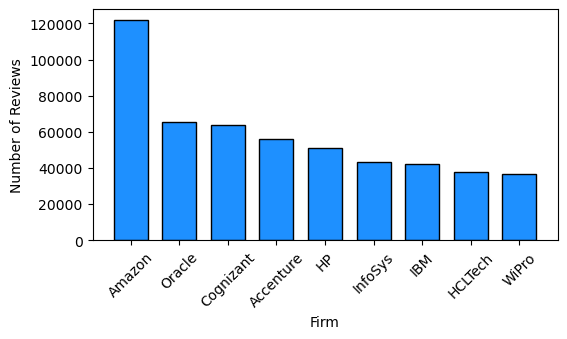

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.bar(over_30k.index.to_list(), height=over_30k, width=0.7, color='dodgerblue', edgecolor='black')
plt.xlabel('Firm')
plt.xticks(rotation=45)
plt.ylabel('Number of Reviews')
plt.show()

Let's create a review year histogram:

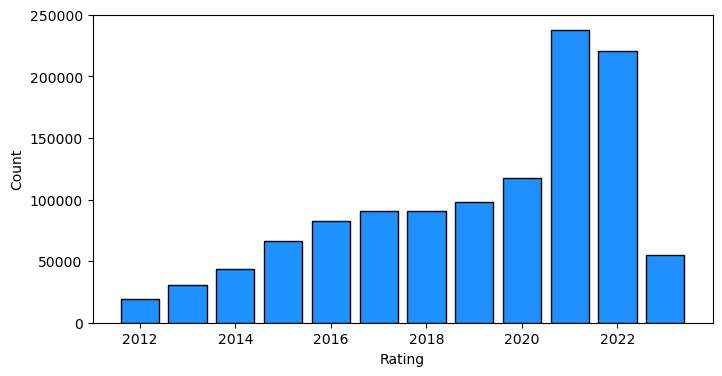

In [177]:
year_counts = merged_df['year'].value_counts(sort=False).sort_index().to_list()

x_labels = list(merged_df['year'].unique())

plt.figure(figsize=(8,4))
plt.bar(x_labels, height=year_counts, width=0.8, color='dodgerblue', edgecolor='black')
plt.ylim(top=250000)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

That's a striking observation. Clearly most 

Plotting the review star rating value counts:

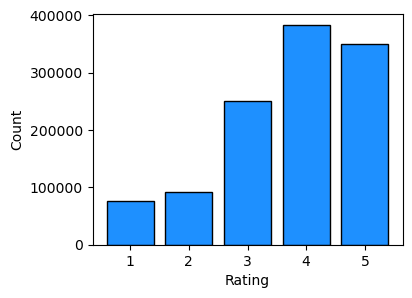

In [143]:
rating_counts = merged_df['rating'].value_counts(sort=False).sort_index().to_list()

plt.figure(figsize=(4,3))
plt.bar([1,2,3,4,5], height=rating_counts, width=0.8, color='dodgerblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Summary statistics for the Positive/Negative columns:

In [151]:
pos_neg_cols = ['Recommend', 'CEO Approval', 'Business Outlook']
pos_neg_stats = merged_df.describe()[pos_neg_cols]
pos_neg_stats = pos_neg_stats.drop(['count','min','25%','50%','75%','max'])
pos_neg_stats

,Recommend,CEO Approval,Business Outlook
mean,2.021244,1.984008,1.903486
std,4.183852,3.329569,3.480278


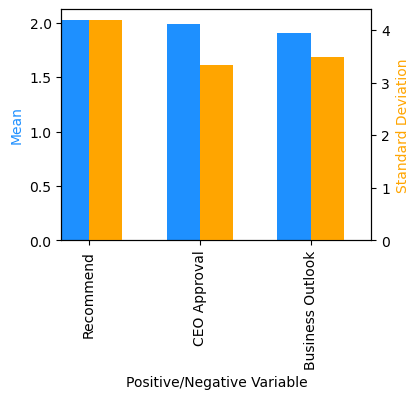

In [155]:
fig = plt.figure(figsize=(4,3))

ax = fig.add_subplot(111)
ax2 = ax.twinx()

pos_neg_stats.loc['mean'].plot(kind='bar', color='dodgerblue', ax=ax, width=0.3, position=1)
pos_neg_stats.loc['std'].plot(kind='bar', color='orange', ax=ax2, width=0.3, position=0)

ax.set_xlabel('Positive/Negative Variable')
ax.set_xticklabels(labels = pos_neg_cols)
ax.set_ylabel('Mean')
ax.yaxis.label.set_color('dodgerblue')
ax2.yaxis.label.set_color('orange')
ax2.set_ylabel('Standard Deviation')

plt.show()

The way to understand the above graph is that reviews generally recommended IT firms more positively than their business outlook.

In [166]:
job_sat_cols = ['Career Opportunities','Compensation and Benefits','Senior Management','Work/Life Balance','Culture & Values']

job_sat_stats = merged_df.describe()[job_sat_cols]
job_sat_stats = job_sat_stats.drop(['count','min','25%','50%','75%','max'])
job_sat_stats

,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values
mean,3.572287,3.512575,3.276769,3.606365,3.706826
std,1.228475,1.190497,1.327884,1.266644,1.283367


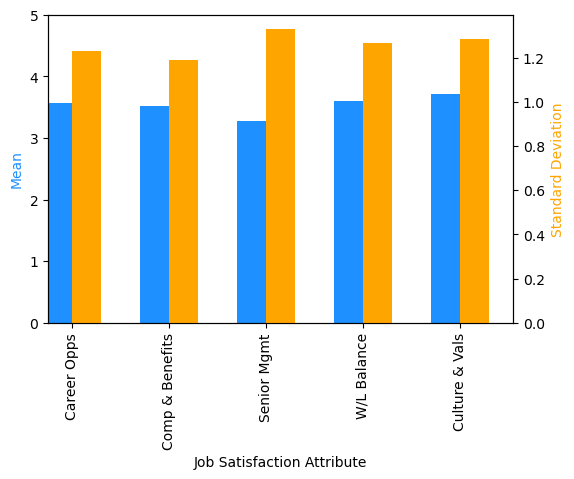

In [181]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(111)
ax2 = ax.twinx()

job_sat_stats.loc['mean'].plot(kind='bar', color='dodgerblue', ax=ax, width=0.3, position=1)
job_sat_stats.loc['std'].plot(kind='bar', color='orange', ax=ax2, width=0.3, position=0)

job_sat_labels = ['Career Opps','Comp & Benefits','Senior Mgmt','W/L Balance','Culture & Vals']

ax.set_xlabel('Job Satisfaction Attribute')
ax.set_xticklabels(labels = job_sat_labels)
ax.set_ylabel('Mean')
ax.set_ylim(top=5)
ax.yaxis.label.set_color('dodgerblue')
ax2.yaxis.label.set_color('orange')
ax2.set_ylabel('Standard Deviation')

plt.show()

Very interesting. People tend to rate **Culture & Values** the **highest**, and **Senior Management** the **lowest**. Notably, Senior Management also **varies the most** - people tend to either love or hate upper management in the IT industry.

## Step 3: Retrieve Yahoo Finance data on company financials

Great, now the next step is to retrieve financials for each company. First we have to decide which financial data to use. We have a number of options:

In [69]:
financials = ['industry']

In [70]:
import yfinance as yf
import requests

stock = yf.Ticker('AAPL')
for key in stock.info.keys():
    print(key)

address1
city
state
zip
country
phone
website
industry
industryKey
industryDisp
sector
sectorKey
sectorDisp
longBusinessSummary
fullTimeEmployees
companyOfficers
auditRisk
boardRisk
compensationRisk
shareHolderRightsRisk
overallRisk
governanceEpochDate
compensationAsOfEpochDate
irWebsite
maxAge
priceHint
previousClose
open
dayLow
dayHigh
regularMarketPreviousClose
regularMarketOpen
regularMarketDayLow
regularMarketDayHigh
dividendRate
dividendYield
exDividendDate
payoutRatio
fiveYearAvgDividendYield
beta
trailingPE
forwardPE
volume
regularMarketVolume
averageVolume
averageVolume10days
averageDailyVolume10Day
bid
ask
bidSize
askSize
marketCap
fiftyTwoWeekLow
fiftyTwoWeekHigh
priceToSalesTrailing12Months
fiftyDayAverage
twoHundredDayAverage
trailingAnnualDividendRate
trailingAnnualDividendYield
currency
enterpriseValue
profitMargins
floatShares
sharesOutstanding
sharesShort
sharesShortPriorMonth
sharesShortPreviousMonthDate
dateShortInterest
sharesPercentSharesOut
heldPercentInsiders
hel

Some good options:

In [71]:
financials = ['overallRisk','fiftyDayAverage','dividendYield','beta','trailingPE','trailingEps','marketCap','enterpriseValue','profitMargins', 'bookValue','earningsQuarterlyGrowth','ebitda','totalRevenue','revenuePerShare','returnOnEquity','earningsGrowth','revenueGrowth']

print(f"{stock.info['shortName']} ({stock.info['symbol']})")
for financial in financials:
    print(f"{financial}: {stock.info[financial]}")

Apple Inc. (AAPL)
overallRisk: 1
fiftyDayAverage: 215.2808
dividendYield: 0.0046
beta: 1.244
trailingPE: 33.678844
trailingEps: 6.57
marketCap: 3364211392512
enterpriseValue: 3346859032576
profitMargins: 0.26441
bookValue: 4.382
earningsQuarterlyGrowth: 0.079
ebitda: 131781001216
totalRevenue: 385603010560
revenuePerShare: 24.957
returnOnEquity: 1.60583
earningsGrowth: 0.111
revenueGrowth: 0.049


Seeing if I can get AAPL's EPS in Q1 2018 as an example:

In [72]:
stock = yf.Ticker('AAPL')
stock.financials

,2023-09-30,2022-09-30,2021-09-30,2020-09-30
Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0
Tax Rate For Calcs,0.147,0.162,0.133,0.144
Normalized EBITDA,129188000000.0,133138000000.0,123136000000.0,81020000000.0
Net Income From Continuing Operation Net Minority Interest,96995000000.0,99803000000.0,94680000000.0,57411000000.0
Reconciled Depreciation,11519000000.0,11104000000.0,11284000000.0,11056000000.0
Reconciled Cost Of Revenue,214137000000.0,223546000000.0,212981000000.0,169559000000.0
EBITDA,129188000000.0,133138000000.0,123136000000.0,81020000000.0
EBIT,117669000000.0,122034000000.0,111852000000.0,69964000000.0
Net Interest Income,-183000000.0,-106000000.0,198000000.0,890000000.0
Interest Expense,3933000000.0,2931000000.0,2645000000.0,2873000000.0


In [73]:
stock.quarterly_income_stmt

,2024-06-30,2024-03-31,2023-12-31,2023-09-30,2023-06-30,2023-03-31,2022-12-31
Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0,0.0,NaN,NaN
Tax Rate For Calcs,0.159,0.158,0.159,0.149715,0.125,NaN,NaN
Normalized EBITDA,28202000000.0,30736000000.0,43221000000.0,30653000000.0,26050000000.0,NaN,NaN
Net Income From Continuing Operation Net Minority Interest,21448000000.0,23636000000.0,33916000000.0,22956000000.0,19881000000.0,NaN,NaN
Reconciled Depreciation,2850000000.0,2836000000.0,2848000000.0,2653000000.0,3052000000.0,NaN,NaN
Reconciled Cost Of Revenue,46099000000.0,48482000000.0,64720000000.0,49071000000.0,45384000000.0,NaN,NaN
EBITDA,28202000000.0,30736000000.0,43221000000.0,30653000000.0,26050000000.0,NaN,NaN
EBIT,25352000000.0,27900000000.0,40373000000.0,28000000000.0,22998000000.0,NaN,NaN
Net Interest Income,NaN,NaN,NaN,-18000000.0,-18000000.0,-12000000.0,-135000000.0
Interest Expense,NaN,NaN,NaN,1002000000.0,998000000.0,930000000.0,1003000000.0


In [74]:
samsung = yf.Ticker('005930.KS')
samsung.get_earnings_dates(limit=20)

,EPS Estimate,Reported EPS,Surprise(%)
Earnings Date,,,
2025-07-29 19:00:00+09:00,NaN,NaN,NaN
2025-04-28 19:00:00+09:00,NaN,NaN,NaN
2025-01-29 19:00:00+09:00,NaN,NaN,NaN
2024-10-29 19:00:00+09:00,NaN,NaN,NaN
2024-07-31 19:00:00+09:00,1255.02,NaN,NaN
2024-07-31 08:00:00+09:00,1255.02,1419.0,0.1307
2024-04-30 19:00:00+09:00,790.95,975.0,0.2327
2024-04-30 08:00:00+09:00,790.95,975.0,0.2327
2024-01-31 08:00:00+09:00,407.77,887.0,1.1753


In [75]:
samsung.get_cash_flow(pretty=True, freq='quarterly')

,2023-12-31,2023-09-30,2023-06-30,2023-03-31,2022-12-31
Free Cash Flow,4057593000000.0,-3921732000000.0,-8510566000000.0,-8022035000000.0,1146955000000.0
Repayment Of Debt,354993000000.0,472808000000.0,-1010736000000.0,-1036644000000.0,-2379495000000.0
Issuance Of Debt,2265657000000.0,41176000000.0,135243000000.0,58036000000.0,128526000000.0
Capital Expenditure,-15887636000000.0,-13652241000000.0,-16680481000000.0,-14313809000000.0,-17465945000000.0
End Cash Position,69080893000000.0,75144284000000.0,79919775000000.0,72949377000000.0,49680710000000.0
Beginning Cash Position,75144284000000.0,79919775000000.0,72949377000000.0,49680710000000.0,44515421000000.0
Effect Of Exchange Rate Changes,-1597742000000.0,874995000000.0,30310000000.0,1485222000000.0,-5092340000000.0
Changes In Cash,-4465649000000.0,-5650486000000.0,6940088000000.0,21783445000000.0,10257629000000.0
Financing Cash Flow,125378000000.0,-1957717000000.0,-5780921000000.0,-979799000000.0,-4705294000000.0
Net Other Financing Charges,72000000.0,-8363000000.0,121000000.0,-948000000.0,797000000.0


SO after a bunch of research and testing it turns out yfinance can't get historical financials, only the 4 or 5 most recent ones. So we have a couple options on how to proceed from here.

### Option 1

We use what we have. We have historical EPS and historical share prices for basically all dates. Of note: stock splits don't affect the stock price data.

### Option 2

We can also consider just using the last 4 years of financials and reviews. From testing it would cut our dataset size by around 60%, and we'd only be able to use yearly performance metrics which would be a fair bit less correlated than quarterly metrics. Meh.

### Option 3

Try to find some other source of financial performance metrics. Compustat seems too difficult to get, and most other services seem to cost a lotta money. Not ideal.

#### Looks like we might be in luck. I'm applying to the WRDS as we speak and waiting for approval from USYD. Once I get that, I'll have access to the full database. That should provide me with a tonne of financial metrics and more. Now, we wait!



Out of the three options, I'm liking Option 1 the most. The reason I'm hesitant with it is because stock prices are affected so heavily by market forces that I suspect it'd make my analysis useless. I'm trying to consider this a little bit. Theoretically if the average review rating doesn't change at all over the lifetime of a company, but the price does change a lot with market forces, then that'd make the linear regression pretty much useless. EPS though would be a much better measure.





If you use historical EPS, be aware of tickers ending in .KS and .T which you may have to divide EPS by 100. To fix, get the most recent EPS of all companies, sort by value and then have a look at like the top 50 and see what needs to be done.

In [76]:
stock.splits

Date
1987-06-16 00:00:00-04:00    2.0
2000-06-21 00:00:00-04:00    2.0
2005-02-28 00:00:00-05:00    2.0
2014-06-09 00:00:00-04:00    7.0
2020-08-31 00:00:00-04:00    4.0
Name: Stock Splits, dtype: float64

In [77]:
stock.dividends

Date
1987-05-11 00:00:00-04:00    0.000536
1987-08-10 00:00:00-04:00    0.000536
1987-11-17 00:00:00-05:00    0.000714
1988-02-12 00:00:00-05:00    0.000714
1988-05-16 00:00:00-04:00    0.000714
                               ...   
2023-08-11 00:00:00-04:00    0.240000
2023-11-10 00:00:00-05:00    0.240000
2024-02-09 00:00:00-05:00    0.240000
2024-05-10 00:00:00-04:00    0.250000
2024-08-12 00:00:00-04:00    0.250000
Name: Dividends, Length: 84, dtype: float64

In [78]:
avgo = yf.Ticker('AVGO')
print(avgo.history(interval="3mo", start="2018-01-01", end="2024-08-01"))

                                 Open        High         Low       Close  \
Date                                                                        
2018-01-01 00:00:00-05:00   20.867692   22.031696   18.066536   18.930099   
2018-04-01 00:00:00-04:00   19.068913   22.154824   18.093256   19.777222   
2018-07-01 00:00:00-04:00   19.831798   20.799062   16.310495   20.380272   
2018-10-01 00:00:00-04:00   20.628988   21.769957   17.329248   21.161606   
2019-01-01 00:00:00-05:00   20.927950   25.507121   19.370443   25.289305   
2019-04-01 00:00:00-04:00   25.718849   27.423482   21.220108   24.424887   
2019-07-01 00:00:00-04:00   25.842928   26.191579   22.486637   23.649090   
2019-10-01 00:00:00-04:00   24.056900   28.632786   23.101610   27.320450   
2020-01-01 00:00:00-05:00   27.885372   28.956007   13.594251   20.705317   
2020-04-01 00:00:00-04:00   20.248185   29.140016   19.510160   28.029869   
2020-07-01 00:00:00-04:00   28.273781   34.002831   27.293068   32.689232   

## Important: Yahoo returns maximum 4 years or 5 quarters, regardless of start_date.

# Note: stopping programming here because I have everything I need to write the Progress Report - we have plenty of Preliminary Results in regards to the total dataset we have. Lots to talk about. Continue on after the report is complete.

YFinance allows for 8000 GET requests per day, which is more than enough for our 318 companies. Let's check that YFinance actually has data for all of our tickers.

In [79]:
ticker_infos = []
for ticker in tickers_df['Ticker']:
    ticker_info = yf.Ticker(ticker)
    ticker_infos.append(ticker_info)

In [80]:
print(ticker_infos[300].info)

{'address1': '177 Huntington Avenue', 'address2': 'Suite 1703 PMB 73480', 'city': 'Boston', 'state': 'MA', 'zip': '02115', 'country': 'United States', 'phone': '978 897 0100', 'website': 'https://www.seachange.com', 'industry': 'Software - Application', 'industryKey': 'software-application', 'industryDisp': 'Software - Application', 'sector': 'Technology', 'sectorKey': 'technology', 'sectorDisp': 'Technology', 'longBusinessSummary': "SeaChange International, Inc. provides video delivery, advertising, streaming platforms, and emerging Free Ad-Supported Streaming TV (FAST) products and services that facilitate the aggregation, licensing, management and distribution of video and advertising content worldwide. It offers Operator TV Platform solutions including customer's current network with OTT video management solutions in a single deployment, digital video broadcasting - cable / quadrature amplitude modulation networks with OTT streaming, and immersive multiscreen experience and on dema

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## POTENTIAL SOURCES OF FIN DATA
https://wrds-www.wharton.upenn.edu/pages/grid-items/compustat-global-wrds-basics/

https://finance.yahoo.com/quote/%5ENDXT/components/

https://www.tradingview.com/symbols/NASDAQ-NDXT/components/

https://medium.com/@kasperjuunge/yfinance-10-ways-to-get-stock-data-with-python-6677f49e8282


## Step 3: Exploratory data analysis

In [81]:
print(merged_df.info())



# print(stock.get_shares_full(start="2022-01-01"))
# print(stock.get_financials())

<class 'pandas.core.frame.DataFrame'>
Index: 1152488 entries, 0 to 1152492
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   rating                     1152488 non-null  float64
 1   title                      1152488 non-null  object 
 2   status                     1152488 non-null  object 
 3   pros                       1152488 non-null  object 
 4   cons                       1152488 non-null  object 
 5   Recommend                  1152488 non-null  object 
 6   CEO Approval               1152488 non-null  object 
 7   Business Outlook           1152488 non-null  object 
 8   Career Opportunities       1152488 non-null  float64
 9   Compensation and Benefits  1152488 non-null  float64
 10  Senior Management          1152488 non-null  float64
 11  Work/Life Balance          1152488 non-null  float64
 12  Culture & Values           1152488 non-null  float64
 13  firm             

In [103]:
merged_df.head(5)

,rating,title,status,pros,cons,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,firm,date,job,Ticker
0,5.0,It was a good culture,Former Employee,- work from home -good culture -great benefits,-some managers shouldn't be managers,5.0,5.0,0.0,5.0,5.0,5.0,5.0,5.0,microsoft,"Mar 24, 2023",Customer Success Manager (CSM),MSFT
1,5.0,Always-changing career and technology opportun...,"Current Employee, more than 10 years",Easy to make an impact on many people around t...,Extreme bureaucracy: random never-ending compl...,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,microsoft,"Mar 19, 2023",Principal Program Manager Lead,MSFT
2,3.0,Does not deserve the reputation of good cultur...,"Former Employee, more than 5 years","1. If you have a good manager, definitely your...","1. If your manager is not good, then your life...",-5.0,-5.0,-5.0,3.0,4.0,1.0,2.0,1.0,microsoft,"Mar 16, 2023",Software Engineer II,MSFT
3,4.0,Great company to work in,"Current Employee, more than 1 year",. Nice Pay . WFH first culture . Great office ...,. Recent layoffs across the company shocked ma...,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,microsoft,"Mar 23, 2023",Software Engineer,MSFT
4,5.0,Amazing culture,"Former Employee, more than 1 year",Their work culture is amazing! People are supe...,Higher-up leadership members may happen to not...,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,microsoft,"Mar 21, 2023",Customer Advisor,MSFT


## Step 4: Data cleaning and feature transformation

## Step 5: Combine datasets

How to convert employee status to employee retention?